# Covid by race data processing

This notebook pre-processes a csv available from  https://covidtracking.com/race .

# Libraries

In [1]:
library(tidyverse)
library(tidyquant)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lubridate


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: PerformanceAnalytics

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘xts’


The following objects are masked from ‘package:dplyr’:

    first, last



Attaching package: ‘PerformanceAnalytics’


The following object is masked from ‘package:graphics’:

    legend


Loading r

# Input

## Read

**Go to https://covidtracking.com/race and update the link below.  It updates on every upload.**

In [2]:
url <- "https://docs.google.com/spreadsheets/d/e/2PACX-1vS8SzaERcKJOD_EzrtCDK1dX1zkoMochlA9iHoHg_RSw3V8bkpfk1mpw4pfL5RdtSOyx_oScsUtyXyk/pub?gid=43720681&single=true&output=csv"

In [3]:
covidByStateRaw <- read_csv(url, col_types = cols(
     .default = col_double(),
     State = col_character()))

This is what it looks like-- a very wide data set with lots of columns.

In [4]:
head(covidByStateRaw, 1)

Date,State,Cases_Total,Cases_White,Cases_Black,Cases_Latinx,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,⋯,Tests_Latinx,Tests_Asian,Tests_AIAN,Tests_NHPI,Tests_Multiracial,Tests_Other,Tests_Unknown,Tests_Ethnicity_Hispanic,Tests_Ethnicity_NonHispanic,Tests_Ethnicity_Unknown
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20210307,AK,59332,18300,1499,NA,2447,12238,1508,4453,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## Pivoting

Pivoting: The data has a separate column for each race's covid cases and deaths.  That's a lot of columns.  The pivot turns the columns into rows, adding a new column, Race, to track which data is counted.

In [5]:
keyCols <- c("Date", "State")
valCols <- c("Cases_White", "Cases_Black", "Cases_Latinx", "Cases_Asian", "Cases_AIAN", "Cases_NHPI", "Cases_Multiracial", "Cases_Other", "Cases_Unknown")

cases <- pivot_longer(covidByStateRaw[c(keyCols, valCols)], all_of(valCols), names_to="Race", names_pattern = "Cases_(.*)", values_to="Cases")

What it looks like now-- rows are good but lots of NA.

In [6]:
head(cases, 6)

Date,State,Race,Cases
<dbl>,<chr>,<chr>,<dbl>
20210307,AK,White,18300
20210307,AK,Black,1499
20210307,AK,Latinx,NA
20210307,AK,Asian,2447
20210307,AK,AIAN,12238
20210307,AK,NHPI,1508


Do the same pivot for deaths

In [7]:
keyCols <- c("Date", "State")
valCols <- c("Deaths_White", "Deaths_Black", "Deaths_Latinx", "Deaths_Asian", "Deaths_AIAN", "Deaths_NHPI", "Deaths_Multiracial", "Deaths_Other", "Deaths_Unknown")

deaths <- pivot_longer(covidByStateRaw[c(keyCols, valCols)], all_of(valCols), names_to="Race", names_pattern = "Deaths_(.*)", values_to="Deaths")

Join the cases and deaths into one table.

In [8]:
covidJoin <- full_join(cases, deaths)
head(covidJoin, 3)

Joining, by = c("Date", "State", "Race")



Date,State,Race,Cases,Deaths
<dbl>,<chr>,<chr>,<dbl>,<dbl>
20210307,AK,White,18300,127
20210307,AK,Black,1499,9
20210307,AK,Latinx,NA,NA


## Handling NA

Let's focus on a subset of data-- Arkansas for AIAN race-- to see how the NAs will be handled.

In [9]:
covidClean <- covidJoin

In [10]:
tmp <- covidClean[covidClean$State=="AK",]
head(tmp[tmp$Race=="AIAN",] %>% arrange(Date), 15)

Date,State,Race,Cases,Deaths
<dbl>,<chr>,<chr>,<dbl>,<dbl>
20200412,AK,AIAN,NA,NA
20200415,AK,AIAN,13,2
20200419,AK,AIAN,14,2
20200422,AK,AIAN,18,2
20200426,AK,AIAN,18,2
20200429,AK,AIAN,19,NA
20200503,AK,AIAN,22,NA
20200506,AK,AIAN,22,NA
20200510,AK,AIAN,24,NA


Apply the fill function to replace an NA with a value from the previous date, if it had a value.  (An alternative would have been to interpolate, but let's keep it simple for now.)****

In [11]:
covidClean <- covidClean %>% group_by(State, Race) %>% arrange(Date, .by_group = TRUE) %>% fill(Cases, Deaths, .direction = "down")

Here's the Arkansas AIAN data-- all NAs gone except at the start.
* The stretch of NA's in Deaths from 20200429 to 20200524 has been filled in with 2's, the value last seen (on 20200426).

In [12]:
tmp <- covidClean[covidClean$State=="AK",]
head(tmp[tmp$Race=="AIAN",] %>% arrange(Date), 15)

Date,State,Race,Cases,Deaths
<dbl>,<chr>,<chr>,<dbl>,<dbl>
20200412,AK,AIAN,NA,NA
20200415,AK,AIAN,13,2
20200419,AK,AIAN,14,2
20200422,AK,AIAN,18,2
20200426,AK,AIAN,18,2
20200429,AK,AIAN,19,2
20200503,AK,AIAN,22,2
20200506,AK,AIAN,22,2
20200510,AK,AIAN,24,2


The NA at the start might be zero... but I think it's more likely the same as the most recent data.  For example, a jump in cases from 0 to 13 seems less likely to me than staying at 13.  This requires a fill in the direction "up" rather than "down."

In [13]:
covidClean <- covidClean %>% group_by(State, Race) %>% arrange(Date, .by_group = TRUE) %>% fill(Cases, Deaths, .direction = "up")

Now let's look again at that Arkansas AIAN data.

In [14]:
tmp <- covidClean[covidClean$State=="AK",]
head(tmp[tmp$Race=="AIAN",] %>% arrange(Date), 15)

Date,State,Race,Cases,Deaths
<dbl>,<chr>,<chr>,<dbl>,<dbl>
20200412,AK,AIAN,13,2
20200415,AK,AIAN,13,2
20200419,AK,AIAN,14,2
20200422,AK,AIAN,18,2
20200426,AK,AIAN,18,2
20200429,AK,AIAN,19,2
20200503,AK,AIAN,22,2
20200506,AK,AIAN,22,2
20200510,AK,AIAN,24,2


## Weekly

You might have noticed gaps in days in the Date column.  In fact only certain days of the week are available-- Sundays and Wednesdays.

In [15]:
covidDay <- covidClean
covidDay[["DateAsDate"]] <- as.Date(as.character(covidDay[["Date"]]), "%Y%m%d")
covidDay[["Weekday"]] <- weekdays(covidDay[["DateAsDate"]])
unique(covidDay$Weekday)

[1] "Sunday"    "Wednesday"

There are 3 days from Sunday to Wednesday and 4 days from Wednesday to Sunday.  Inconsistent spacing is more difficult to handle correctly, so let's just use Sundays so we have data every 7 days.

In [16]:
covidWeekly <- covidClean[covidDay$Weekday=="Sunday",]
covidWeekly[["DateAsDate"]] <- as.Date(as.character(covidWeekly[["Date"]]), "%Y%m%d")

## Outliers: Identifying and cleaning with Hampel filter

When doing plotting, I noticed some severe outliers such as the one below, jumping from 2 deaths to 512 and back to 2.  We don't want to build a model with such obviously wrong data, so we want to replace the 512 by values similar to those before and after.

In [17]:
tmp <- covidByStateRaw[covidByStateRaw$State=="IL", c("Date", "Deaths_AIAN")]
tmp[tmp$Date <= 20200426,] %>% arrange(Date)

Date,Deaths_AIAN
<dbl>,<dbl>
20200412,2
20200415,1
20200419,512
20200422,1
20200426,2


Practice a new way to identify outliers and impute below.

In [18]:
covidMad <- covidWeekly %>%
  group_by(State, Race) %>%
  arrange(Date) %>%
    tq_mutate(
        # tq_mutate args
        select     = Cases,
        mutate_fun = rollapply,
        # rollapply args
        width      = 9,
        # partial    = TRUE,
        align      = "center",
        FUN        = mad,
        # mad args
        # tq_mutate args
        col_rename = "CasesMad_9"
    )%>%
    tq_mutate(
        # tq_mutate args
        select     = Cases,
        mutate_fun = rollapply,
        # rollapply args
        width      = 7,
        # partial    = TRUE,
        align      = "center",
        FUN        = mad,
        # mad args
        # tq_mutate args
        col_rename = "CasesMad_7"
    ) %>%
    tq_mutate(
        # tq_mutate args
        select     = Cases,
        mutate_fun = rollapply,
        # rollapply args
        width      = 5,
        # partial    = TRUE,
        align      = "center",
        FUN        = mad,
        # mad args
        # tq_mutate args
        col_rename = "CasesMad_5"
    ) %>%
    tq_mutate(
        # tq_mutate args
        select     = Cases,
        mutate_fun = rollapply,
        # rollapply args
        width      = 3,
        # partial    = TRUE,
        align      = "center",
        FUN        = mad,
        # mad args
        # tq_mutate args
        col_rename = "CasesMad_3"
    ) %>% 
    mutate(
        CasesMad = coalesce(CasesMad_9, CasesMad_7, CasesMad_5, CasesMad_3), 
    )

In [19]:
head(covidMad)

State,Race,Date,Cases,Deaths,DateAsDate,CasesMad_9,CasesMad_7,CasesMad_5,CasesMad_3,CasesMad
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AK,AIAN,20200412,13,2,2020-04-12,NA,NA,NA,NA,NA
AK,AIAN,20200419,14,2,2020-04-19,NA,NA,NA,1.4826,1.4826
AK,AIAN,20200426,18,2,2020-04-26,NA,NA,5.9304,5.9304,5.9304
AK,AIAN,20200503,22,2,2020-05-03,NA,10.3782,5.9304,2.9652,10.3782
AK,AIAN,20200510,24,2,2020-05-10,13.3434,8.8956,7.4130,2.9652,13.3434
AK,AIAN,20200517,29,2,2020-05-17,16.3086,10.3782,7.4130,5.9304,16.3086


In [20]:
tail(covidMad)

State,Race,Date,Cases,Deaths,DateAsDate,CasesMad_9,CasesMad_7,CasesMad_5,CasesMad_3,CasesMad
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WY,White,20210131,26384,499,2021-01-31,1733.159,1276.5186,1074.8850,796.1562,1733.1594
WY,White,20210207,26921,550,2021-02-07,1406.987,937.0032,796.1562,480.3624,1406.9874
WY,White,20210214,27245,572,2021-02-14,NA,926.6250,480.3624,456.6408,926.6250
WY,White,20210221,27553,588,2021-02-21,NA,NA,469.9842,456.6408,469.9842
WY,White,20210228,27870,595,2021-02-28,NA,NA,NA,366.2022,366.2022
WY,White,20210307,28117,606,2021-03-07,NA,NA,NA,NA,NA


In [21]:
covidMad[(covidMad$Cases > 3 * covidMad$CasesMad),]

State,Race,Date,Cases,Deaths,DateAsDate,CasesMad_9,CasesMad_7,CasesMad_5,CasesMad_3,CasesMad
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AK,AIAN,20200419,14,2,2020-04-19,NA,NA,NA,1.4826,1.4826
AK,AIAN,20200426,18,2,2020-04-26,NA,NA,5.9304,5.9304,5.9304
AK,AIAN,20201206,7323,54,2020-12-06,2066.7444,1959.9972,1040.7852,874.7340,2066.7444
AK,AIAN,20201213,8025,65,2020-12-13,1915.5192,1399.5744,1040.7852,919.2120,1915.5192
AK,AIAN,20201220,8645,67,2020-12-20,1959.9972,1449.9828,919.2120,480.3624,1959.9972
AK,AIAN,20201227,8969,74,2020-12-27,1881.4194,1399.5744,969.6204,480.3624,1881.4194
AK,AIAN,20210103,9623,76,2021-01-03,1676.8206,1449.9828,969.6204,911.7990,1676.8206
AK,AIAN,20210110,10238,83,2021-01-10,1811.7372,1366.9572,911.7990,765.0216,1811.7372


In [22]:
# covidMad$CasesImputed <= if(covidMad$Cases > 3 * covidMad$CasesMad, covidMad$Cases)

### Library

The pracma library has a function called hampel to do this.

In [23]:
library(pracma)


Attaching package: ‘pracma’


The following object is masked from ‘package:purrr’:

    cross




### Usage

In [24]:
covidToImpute <- covidWeekly

In [25]:
hampelWindow <- 5
hampelThreshold <- 3

In [26]:
states <- unique(covidToImpute$State)
races <- unique(covidToImpute$Race)
datalist = list()
countlist = list()
i <- 1
for (state in states) {
    for (race in races) {
        oneState <- covidToImpute[covidToImpute$State == state,]
        oneStateOneRace <- oneState[oneState$Race == race,]
        len <- nrow(oneStateOneRace)
        if (len > 0  && sum(is.na(oneStateOneRace$Cases))<len && sum(is.na(oneStateOneRace$Deaths))<len) {
            h1 <- hampel(oneStateOneRace$Cases, hampelWindow, hampelThreshold)
            numCaseOutliers <- length(h1$ind) 
            h2 <- hampel(oneStateOneRace$Deaths, hampelWindow, hampelThreshold)
            numDeathOutliers <- length(h2$ind)
            
            df <- data.frame(Date=oneStateOneRace$Date,
                             DateAsDate=oneStateOneRace$DateAsDate,
                             State=rep(state, len),
                             Race=rep(race, len),
                             Cases <- h1$y, Deaths <- h2$y)
            datalist[[i]] <- df
            countlist[[i]] <- data.frame(State=state, Race=race,
                             NumCaseOutliers=length(h1$ind),
                             NumDeathOutliers=length(h2$ind))
          i <- i+1
        }
    }
}
numOutliers <- dplyr::bind_rows(countlist)
covidImputed <- dplyr::bind_rows(datalist)
names(covidImputed) <- c("Date", "DateAsDate", "State", "Race", "Cases", "Deaths")

In [27]:
nrow(covidImputed)

[1] 17088

How many data points did this affect?

In [28]:
data.frame(NumCaseImputed=sum(numOutliers$NumCaseOutliers), NumDeathImputed=sum(numOutliers$NumDeathOutliers))

NumCaseImputed,NumDeathImputed
<int>,<int>
37,121


Which cases had values imputed?  Let's look at a few examples.

In [29]:
head(numOutliers[numOutliers$NumCaseOutliers > 0,])

,State,Race,NumCaseOutliers,NumDeathOutliers
,<fct>,<fct>,<int>,<int>
3,AK,Black,1,0
27,AZ,Unknown,1,0
31,CA,Black,1,0
65,DE,Unknown,2,2
91,HI,White,1,0
94,IA,Black,1,0


We know data for Unknown races tends to be messy (leftovers not counted elsewehre), so let's focus on the first non-Unknown, HI White cases

### Example cleaning: HI White

Let's look at before and after plots.  Below I apply hampel again directly.  $ind returns the indices of any outliers.

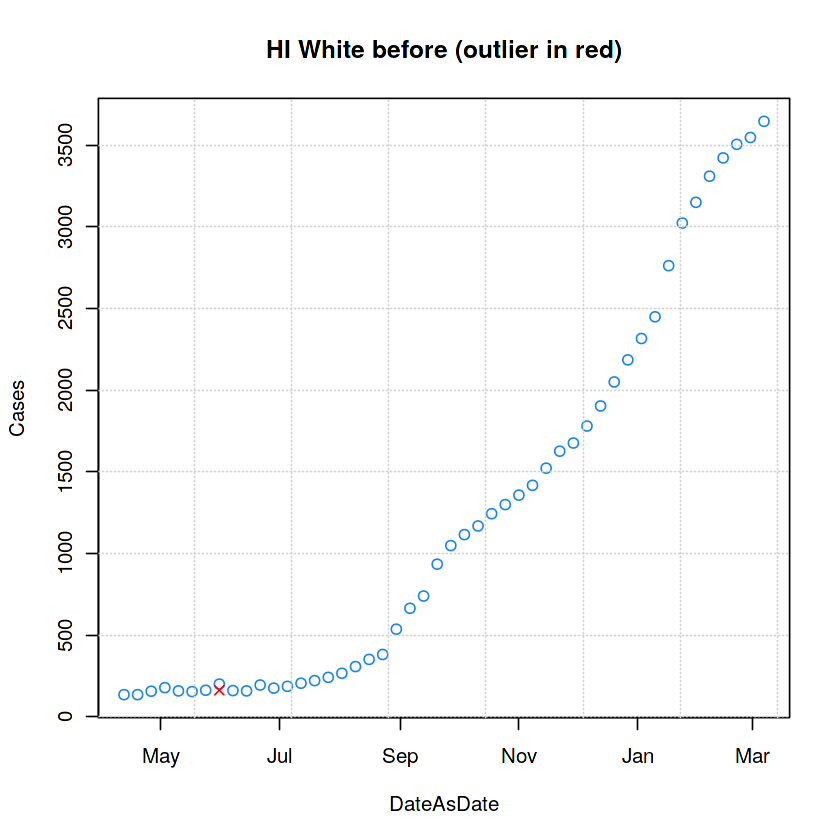

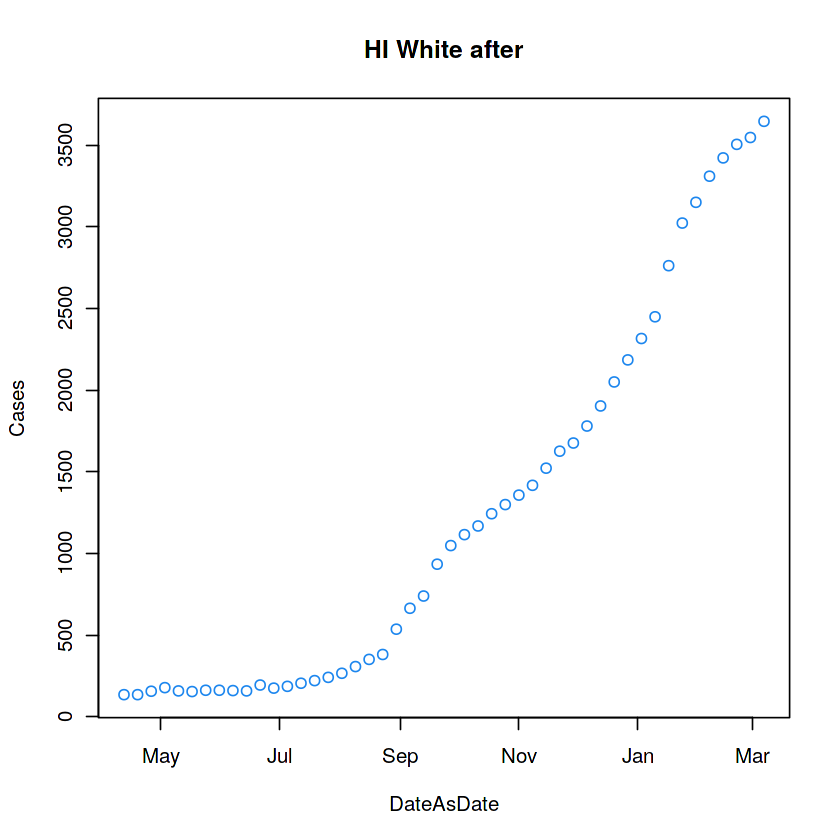

In [30]:
ts <- covidWeekly %>% filter(State=="HI" && Race=="White")
plot(ts[,c("DateAsDate", "Cases")], col="dodgerblue2",
     main = "HI White before (outlier in red)" )
ts.hampel <- hampel(ts$Cases, hampelWindow, hampelThreshold)
points(ts$DateAsDate[ts.hampel$ind], ts.hampel$y[ts.hampel$ind],
    pch=4, col="red")
grid()

tmp <- covidImputed[(covidImputed$State == "HI"),]
ts <- tmp[(tmp$Race=="White"),]
plot(ts[,c("DateAsDate", "Cases")], col="dodgerblue2",
     main = "HI White after" )

Arizona unknown-- a data point is changed, but since it was a level shift it wasn't really necessary.  This justifies not analyzing the race=Unknown data.

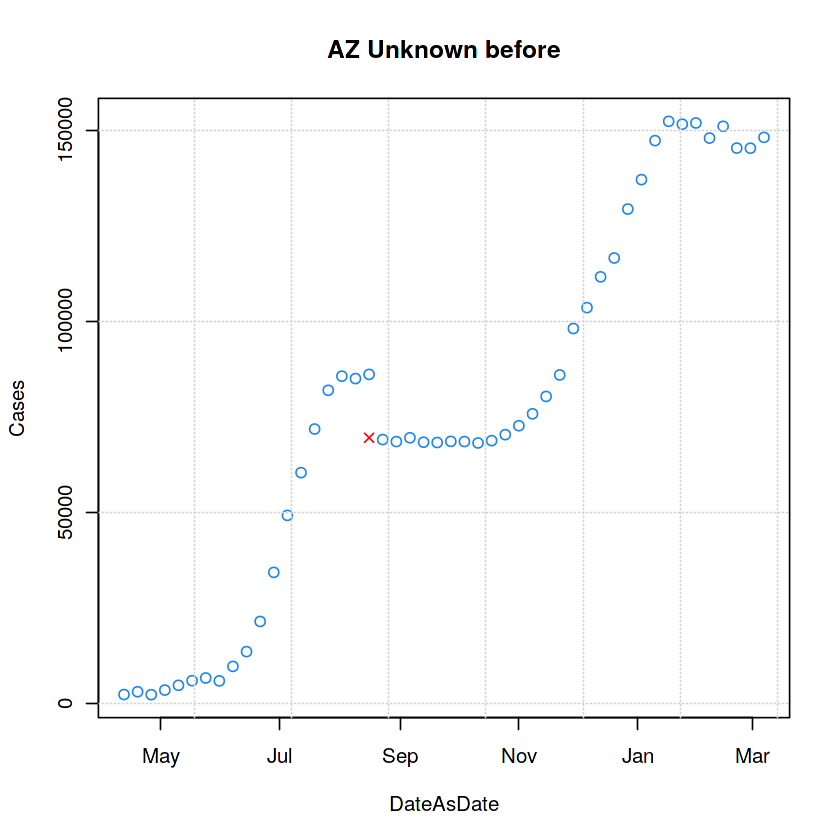

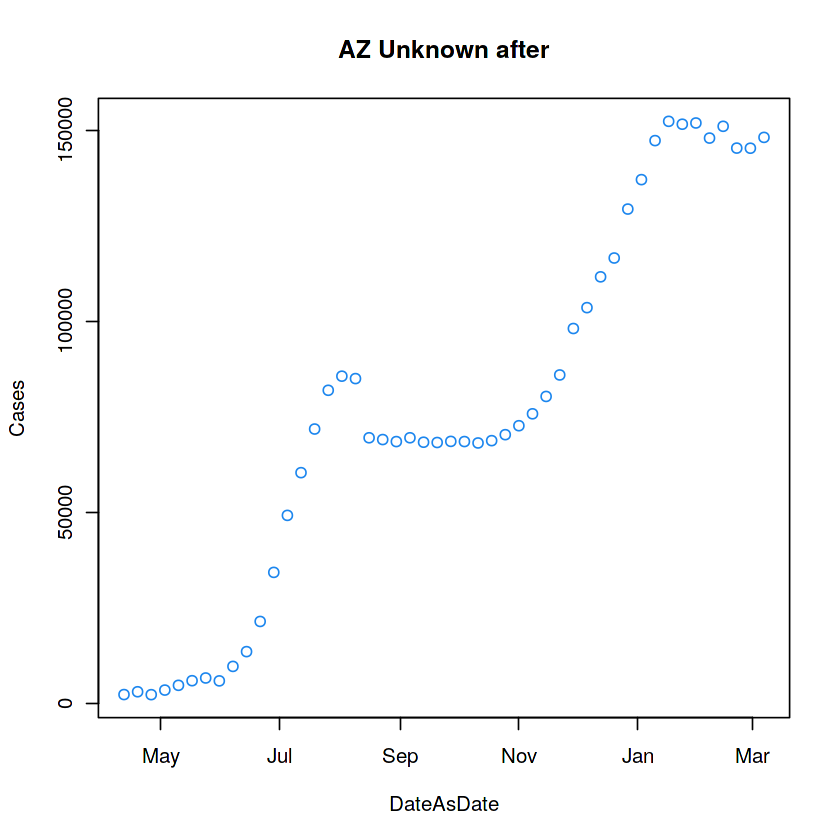

In [31]:
ts <- covidWeekly %>% filter(State=="AZ" && Race=="Unknown")
plot(ts[,c("DateAsDate", "Cases")], col="dodgerblue2",
     main = "AZ Unknown before" )
ts.hampel <- hampel(ts$Cases, hampelWindow, hampelThreshold)
points(ts$DateAsDate[ts.hampel$ind], ts.hampel$y[ts.hampel$ind],
    pch=4, col="red")
grid()

tmp <- covidImputed[(covidImputed$State == "AZ"),]
ts <- tmp[(tmp$Race=="Unknown"),]
plot(ts[,c("DateAsDate", "Cases")], col="dodgerblue2",
     main = "AZ Unknown after" )

### Level shift not captured.

Some level shifts like the one below for Illinois Unknown deaths is not considered an outlier in overall numbers and so is still present in the data set.  But we can do the same outlier analysis for the diffs-- the lagged values where we calculate "New Cases" and "New Deaths."  First lets calculate diffs.

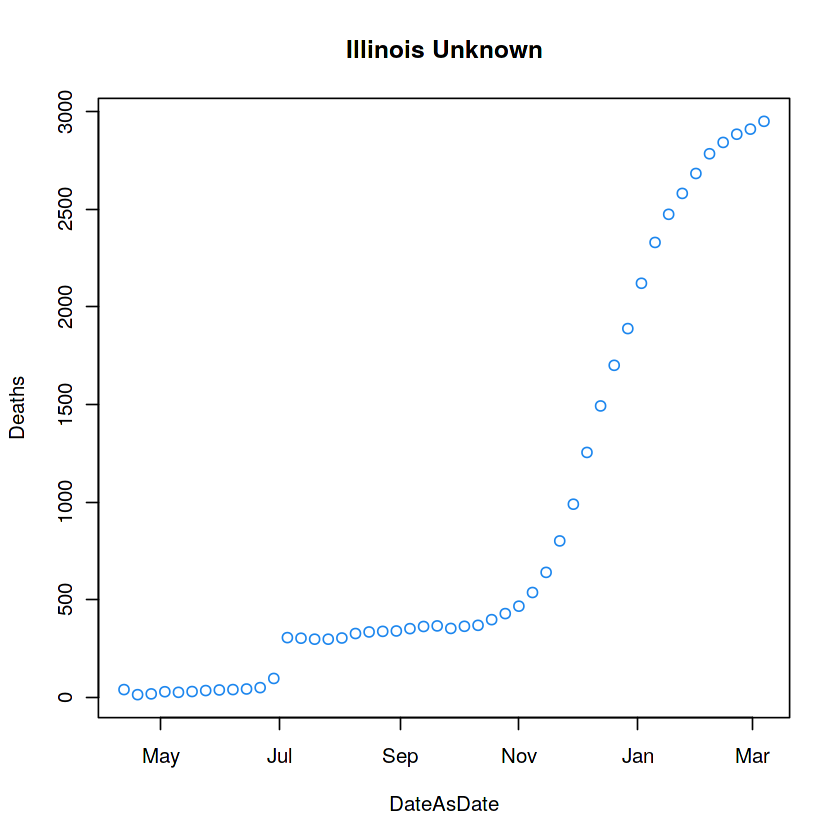

In [32]:
ts <- covidWeekly %>% filter(State=="IL" && Race=="Unknown")
plot(ts[,c("DateAsDate", "Deaths")], col="dodgerblue2",
     main = "Illinois Unknown" )

## New cases and new deaths

A cumulative count drags a lot of past history with it.  Modeling is more easily done on immediate effects.  So let's calculate how many *new* cases or *new* deaths occurred since the previous week.

In [33]:
covidLagged <- covidImputed %>%
     group_by(State, Race) %>%
     arrange(Date, .by_group = TRUE) %>%
     mutate(PrevDate = lag(Date), PrevCases = lag(Cases), PrevDeaths = lag(Deaths))

covidLagged$NewCases <- (covidLagged$Cases - covidLagged$PrevCases)
covidLagged$NewDeaths <- (covidLagged$Deaths - covidLagged$PrevDeaths)

In [34]:
tmp <- covidLagged[covidLagged$State=="AK",]
head(tmp[tmp$Race=="AIAN",] %>% arrange(Date), 15)

Date,DateAsDate,State,Race,Cases,Deaths,PrevDate,PrevCases,PrevDeaths,NewCases,NewDeaths
<dbl>,<date>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20200412,2020-04-12,AK,AIAN,13,2,NA,NA,NA,NA,NA
20200419,2020-04-19,AK,AIAN,14,2,20200412,13,2,1,0
20200426,2020-04-26,AK,AIAN,18,2,20200419,14,2,4,0
20200503,2020-05-03,AK,AIAN,22,2,20200426,18,2,4,0
20200510,2020-05-10,AK,AIAN,24,2,20200503,22,2,2,0
20200517,2020-05-17,AK,AIAN,29,2,20200510,24,2,5,0
20200524,2020-05-24,AK,AIAN,33,2,20200517,29,2,4,0
20200531,2020-05-31,AK,AIAN,41,2,20200524,33,2,8,0
20200607,2020-06-07,AK,AIAN,59,2,20200531,41,2,18,0


## Clean again

Now I am going to remove any row with NA.  There are two cases:
* The first row of every state / race has NA for NewCases and NewDeaths because they are a difference from a previous row and these have no previous row. 
* There are also some state / race combinations that have NAs for everything.  There's nothing to analyze, so let's remove those.

In [35]:
covidLaggedClean <- covidLagged[complete.cases(covidLagged), ]

## Negative new cases and deaths

After plotting and seeing some "oops" data below, I decided to look at cases of negative new cases and deaths.  Below I calculate the min value for each State/Race combination.

In [36]:
covidLaggedClean$DateAsDate <- as.Date(as.character(covidLaggedClean[["Date"]]), "%Y%m%d")

In [37]:
minNewCasesOrDeaths <- covidLaggedClean %>%
  group_by(State, Race) %>%
  group_modify(~ {
     min(min(.x$NewCases), min(.x$NewDeaths)) %>%
     tibble::enframe(value = "min")
  })

How many state / race combinations had some negative?  The summary below shows-- Yikes-- more than half!

In [38]:
data.frame(acceptable= nrow(minNewCasesOrDeaths[minNewCasesOrDeaths$min >= 0,]), hadNegatives=nrow(minNewCasesOrDeaths[minNewCasesOrDeaths$min < 0,]))

acceptable,hadNegatives
<int>,<int>
113,243


If we tolerate up to -10, we can get most of our series to be acceptable.

In [39]:
data.frame(acceptable= nrow(minNewCasesOrDeaths[minNewCasesOrDeaths$min >= -10,]), belowNegative10=nrow(minNewCasesOrDeaths[minNewCasesOrDeaths$min < -10,]))

acceptable,belowNegative10
<int>,<int>
182,174


## Cleaning diff (New Case / Death) outliers with a Hampel filter

In [40]:
library(pracma)

### Illinois AIAN

In [41]:
ts <- covidLaggedClean %>% filter(State=="IL" && Race=="AIAN")

In [42]:
head(ts)

Date,DateAsDate,State,Race,Cases,Deaths,PrevDate,PrevCases,PrevDeaths,NewCases,NewDeaths
<dbl>,<date>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20200419,2020-04-19,IL,AIAN,46,512,20200412,24,2,22,510
20200426,2020-04-26,IL,AIAN,65,2,20200419,46,512,19,-510
20200503,2020-05-03,IL,AIAN,82,3,20200426,65,2,17,1
20200510,2020-05-10,IL,AIAN,126,6,20200503,82,3,44,3
20200517,2020-05-17,IL,AIAN,159,7,20200510,126,6,33,1
20200524,2020-05-24,IL,AIAN,181,7,20200517,159,7,22,0


We are using a window size of 5 and regarding a point more than 3 from hte MAD as an outlier.

In [43]:
ts.hampel <- hampel(ts$NewDeaths, 5, 3)
ts.hampel$ind

[1] 12 19 21 28 30 33 40

Collect times and values at these indices for plotting.

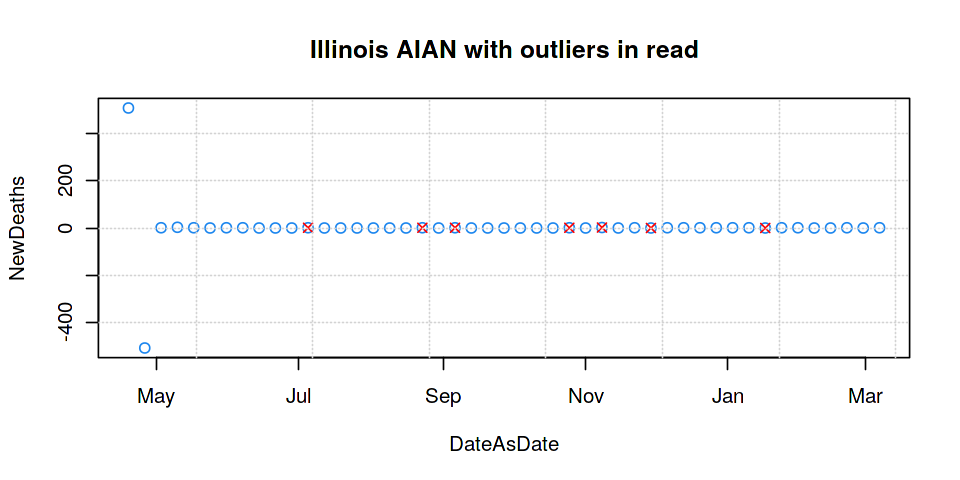

In [44]:
options(repr.plot.width=8, repr.plot.height=4)
plot(ts[,c("DateAsDate", "NewDeaths")], col="dodgerblue2",
     main = "Illinois AIAN with outliers in read" )
points(ts$DateAsDate[ts.hampel$ind], ts$NewDeaths[ts.hampel$ind],
    pch=4, col="red")
grid()

Not great-- it missed the two big outliers at the beginning, and the things it found were unimportant wiggles.

### Illinois Unknown

In [45]:
covidLaggedOneState <- covidLaggedClean[covidLaggedClean$State=="IL",]
ts <- covidLaggedOneState[covidLaggedOneState$Race=="Unknown",]
head(ts, 3)

Date,DateAsDate,State,Race,Cases,Deaths,PrevDate,PrevCases,PrevDeaths,NewCases,NewDeaths
<dbl>,<date>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20200419,2020-04-19,IL,Unknown,7898,15,20200412,5936,41,1962,-26
20200426,2020-04-26,IL,Unknown,11341,19,20200419,7898,15,3443,4
20200503,2020-05-03,IL,Unknown,16517,30,20200426,11341,19,5176,11


In [46]:
ts.hampel <- hampel(ts$NewDeaths, 5, 3)
ts.hampel$ind

[1] 11 12

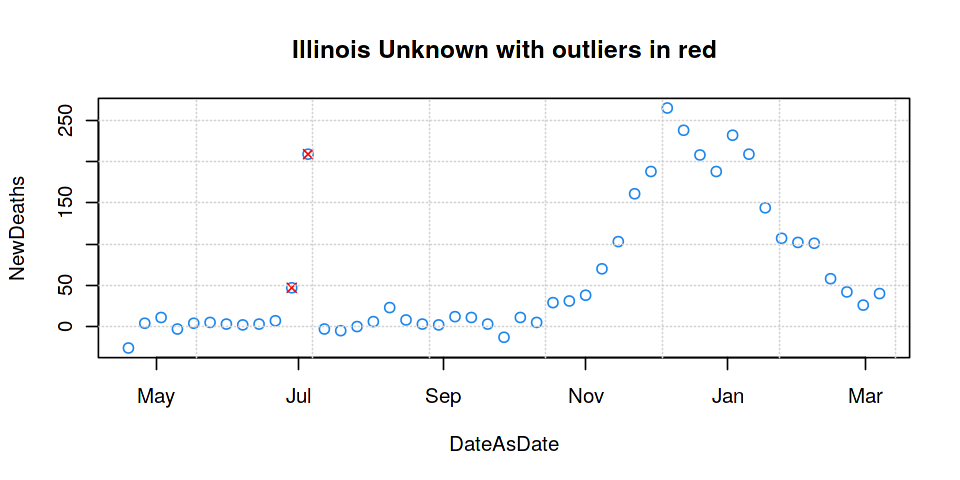

In [47]:
options(repr.plot.width=8, repr.plot.height=4)
plot(ts[,c("DateAsDate", "NewDeaths")], col="dodgerblue2",
     main = "Illinois Unknown with outliers in red" )
points(ts$DateAsDate[ts.hampel$ind], ts$NewDeaths[ts.hampel$ind],
    pch=4, col="red")
grid()

This was a good cleaning job, although it still did miss some negative new deaths.

### Illinois White-- no outliers

In [48]:
covidLaggedOneState <- covidLaggedClean[covidLaggedClean$State=="IL",]
ts <- covidLaggedOneState[covidLaggedOneState$Race=="White",]
head(ts, 3)

Date,DateAsDate,State,Race,Cases,Deaths,PrevDate,PrevCases,PrevDeaths,NewCases,NewDeaths
<dbl>,<date>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20200419,2020-04-19,IL,White,7554,501,20200412,5214,259,2340,242
20200426,2020-04-26,IL,White,10427,794,20200419,7554,501,2873,293
20200503,2020-05-03,IL,White,13566,1096,20200426,10427,794,3139,302


### Apply to all

The code below works but is kinda slow.

In [49]:
hampelWindow <- 5
hampelThreshold <- 3

In [50]:
states <- unique(covidLaggedClean$State)
races <- unique(covidLaggedClean$Race)
datalist = list()
countlist = list()
i <- 1
for (state in states) {
    for (race in races) {
        oneState <- covidLaggedClean[covidLaggedClean$State == state,]
        oneStateOneRace <- oneState[oneState$Race == race,]
        if (nrow(oneStateOneRace) > 0) {
            h1 <- hampel(oneStateOneRace$NewCases, hampelWindow, hampelThreshold)
            numNewCaseOutliers <- length(h1$ind) 
            h2 <- hampel(oneStateOneRace$NewDeaths, hampelWindow, hampelThreshold)
            numNewDeathOutliers <- length(h2$ind)
            len <- length(oneStateOneRace$NewCases)
            df <- data.frame(Date=oneStateOneRace$Date,
                             DateAsDate=oneStateOneRace$DateAsDate,
                             State=rep(state, len),
                             Race=rep(race, len),
                             NewCases <- h1$y, NewDeaths <- h2$y)
            datalist[[i]] <- df
            countlist[[i]] <- data.frame(State=state, Race=race,
                             NumNewCaseOutliers=length(h1$ind),
                             NumNewDeathOutliers=length(h2$ind))
          i <- i+1
        }
    }
}
numOutliers <- dplyr::bind_rows(countlist)
covidImputed <- dplyr::bind_rows(datalist)
names(covidImputed) <- c("Date", "DateAsDate", "State", "Race", "NewCases", "NewDeaths")

In [51]:
nrow(covidImputed)

[1] 16732

Below is one of the cases we saw above where two outliers were identified-- the imputed values look more in line now.

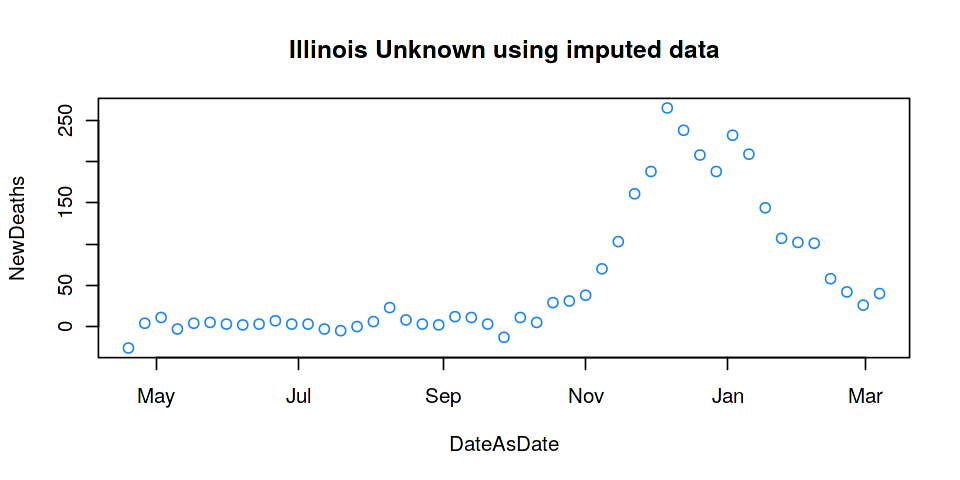

In [52]:
covidOneState <- covidImputed[covidImputed$State=="IL",]
ts <- covidOneState[covidOneState$Race=="Unknown",]
plot(ts[,c("DateAsDate", "NewDeaths")], col="dodgerblue2",
     main = "Illinois Unknown using imputed data" )

In [53]:
head(numOutliers, 3)

,State,Race,NumNewCaseOutliers,NumNewDeathOutliers
,<fct>,<fct>,<int>,<int>
1,AK,AIAN,0,2
2,AK,Asian,5,5
3,AK,Black,2,8


In [54]:
tmp <- numOutliers[numOutliers$State=="IL",]
tmp[tmp$Race %in% c("AIAN", "Unknown", "White"),]

,State,Race,NumNewCaseOutliers,NumNewDeathOutliers
,<fct>,<fct>,<int>,<int>
105,IL,AIAN,0,7
110,IL,Unknown,0,2
111,IL,White,0,0


In [55]:
data.frame(NumNewCaseOutliers=sum(numOutliers$NumNewCaseOutliers), NumNewDeathOutliers=sum(numOutliers$NumNewDeathOutliers))


NumNewCaseOutliers,NumNewDeathOutliers
<int>,<int>
595,987


#### non-iterative way to do the same thing

The code below uses tidyr to the outlier count more efficiently BUT it does not include using the imputed data.

In [56]:
numOutlierNewDeaths <- covidLaggedClean %>%
  group_by(State, Race) %>%
  arrange(Date) %>%
  group_modify(~ {
     length(hampel(.x$NewDeaths, 5, 3)$ind) %>%
     tibble::enframe(value = "NumOutlierNewDeaths")
  })
head(numOutlierNewDeaths, 3)

State,Race,name,NumOutlierNewDeaths
<fct>,<fct>,<int>,<int>
AK,AIAN,1,2
AK,Asian,1,5
AK,Black,1,8


In [57]:
tmp <- numOutlierNewDeaths[numOutlierNewDeaths$State=="IL",]
tmp[tmp$Race %in% c("AIAN", "Unknown","White"),]

State,Race,name,NumOutlierNewDeaths
<fct>,<fct>,<int>,<int>
IL,AIAN,1,7
IL,Unknown,1,2
IL,White,1,0


## Lags

In [58]:
lagRange <- 1:4
col_names <- paste0("NewCases_Lag_", lagRange)

covidImputedLagged <- covidImputed %>%
  group_by(State, Race) %>%
  arrange(Date) %>%
    tq_mutate(
        select     = NewCases,
        mutate_fun = lag.xts,
        k          = lagRange,
        col_rename = col_names
    )

In [59]:
tail(covidImputedLagged)

State,Race,Date,DateAsDate,NewCases,NewDeaths,NewCases_Lag_1,NewCases_Lag_2,NewCases_Lag_3,NewCases_Lag_4
<fct>,<fct>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WY,Latinx,20210131,2021-01-31,84,2,136,156,131,116
WY,Latinx,20210207,2021-02-07,58,6,84,136,156,131
WY,Latinx,20210214,2021-02-14,20,2,58,84,136,156
WY,Latinx,20210221,2021-02-21,23,1,20,58,84,136
WY,Latinx,20210228,2021-02-28,26,0,23,20,58,84
WY,Latinx,20210307,2021-03-07,23,1,26,23,20,58


## Export

Now this data set is ready for export!  Uncomment the line below to export a fresh copy.

In [60]:
# write.csv(covidImputed,"kaggle_imputed.csv", row.names = FALSE)

In [61]:
write.csv(covidImputedLagged,"kaggle_imputed_and_lagged.csv", row.names = FALSE)

In [62]:
nrow(covidImputed)

[1] 16732

In [63]:
# Raw data without anything imputed
# write.csv(covidLaggedClean,"kaggle_covid_new_cases_new_deaths.csv", row.names = FALSE)

# Simple plots and analysis

In [64]:
# covidLaggedClean$DateAsDate <- as.Date(as.character(covidLaggedClean[["Date"]]), "%Y%m%d")

## Libraries

In [65]:
library(ggplot2) # Data visualization
library(scales) # Data visualization (date labels)


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




## Plotting Time Series

Let's pick a state, Illinois, and look at how things have varied.

In [66]:
covidLaggedOneState <- covidLaggedClean[covidLaggedClean$State=="IL",]
covidLaggedOneState <- covidImputed[covidImputed$State=="IL",]
length(unique(covidLaggedOneState$Date))

[1] 47

There will be 33 weeks of data for each race.

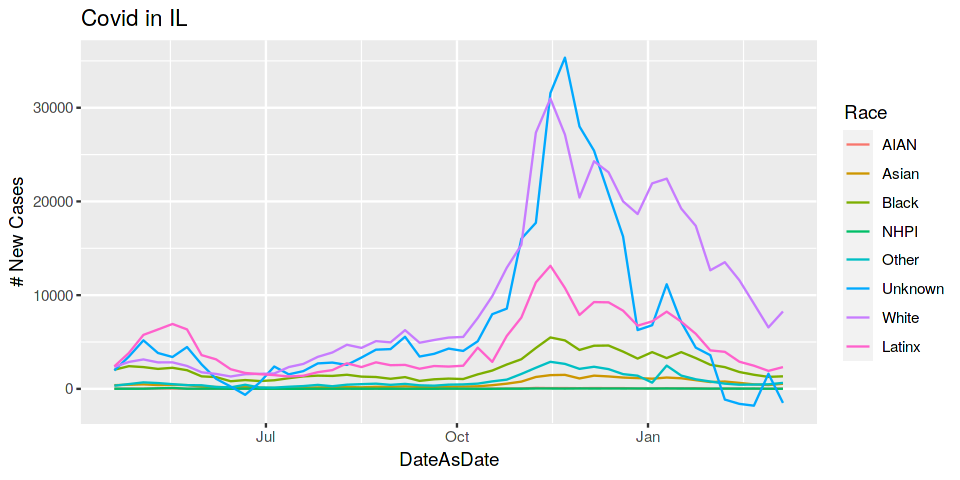

In [67]:
plot <- ggplot(data=covidLaggedOneState, aes(x=DateAsDate, y=NewCases, group=Race, color=Race)) + geom_line()
plot + labs(title="Covid in IL", y="# New Cases")

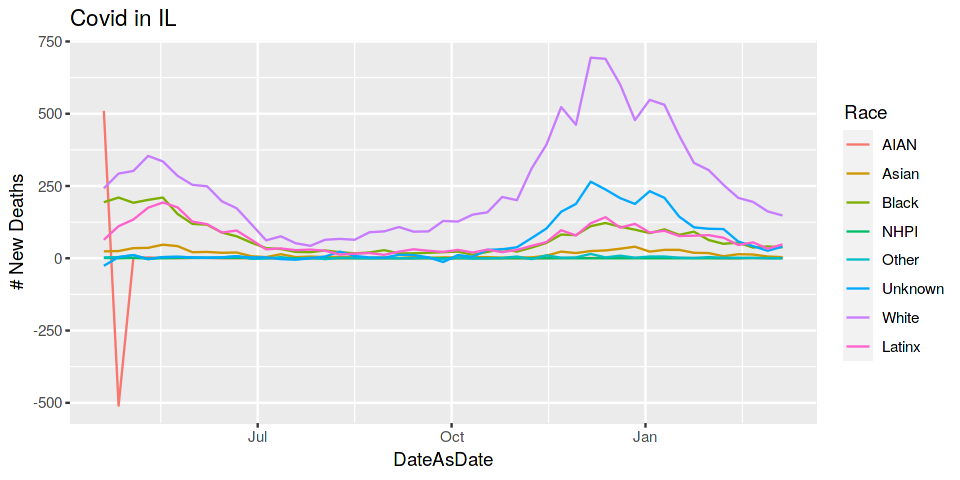

In [68]:
plot <- ggplot(data=covidLaggedOneState, aes(x=DateAsDate, y=NewDeaths, group=Race, color=Race)) + geom_line()
plot + labs(title="Covid in IL", y="# New Deaths")

### Oops

The big negative in new deaths is of course impossible-- it indicates a bad data value.
TODO: Clean data like this for IL and other states.

In [69]:
head(covidLaggedOneState[covidLaggedOneState$Race=="AIAN",], 6)

,Date,DateAsDate,State,Race,NewCases,NewDeaths
,<dbl>,<date>,<fct>,<fct>,<dbl>,<dbl>
4889,20200419,2020-04-19,IL,AIAN,22,510
4890,20200426,2020-04-26,IL,AIAN,19,-510
4891,20200503,2020-05-03,IL,AIAN,17,1
4892,20200510,2020-05-10,IL,AIAN,44,3
4893,20200517,2020-05-17,IL,AIAN,33,1
4894,20200524,2020-05-24,IL,AIAN,22,0


Below I confirm the anomalous value of 512 is in the original data, before I started processing.

In [70]:
tmp <- covidByStateRaw[covidByStateRaw$State=="IL", c("Date", "Deaths_AIAN")]
tmp[tmp$Date <= 20200426,] %>% arrange(Date)

Date,Deaths_AIAN
<dbl>,<dbl>
20200412,2
20200415,1
20200419,512
20200422,1
20200426,2


I won't analyze data on AIAN until that bad data is cleaned up.  (Notice also cumulative deaths go down, but at least it's only off by one rather than 512.)

## Autocorrelation and cross correlation

Auto and cross correlations need to be within each state and ethnic group, so I need to work on a general function, but here it is for a few racial groups.

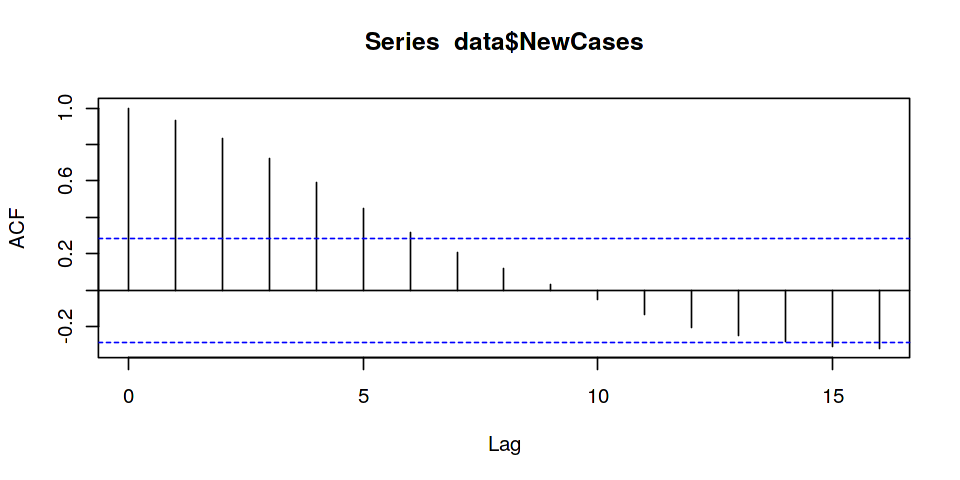

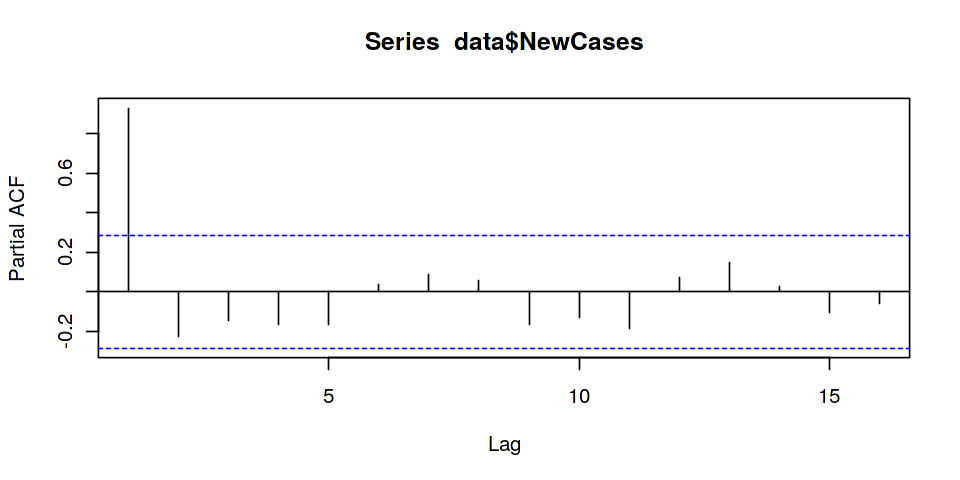

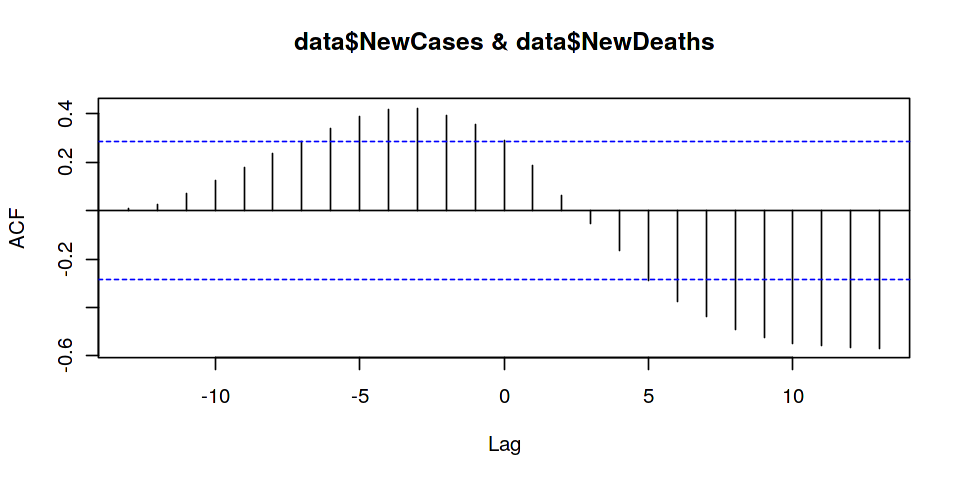

In [71]:
data <- covidLaggedOneState
data <- data[data$Race=="Black", ]
acf(data$NewCases)
pacf(data$NewCases)
ccf(data$NewCases, data$NewDeaths)

In [72]:
data <- covidLaggedOneState
data <- data[data$Race=="LatinX", ]
acf(data$NewCases)
pacf(data$NewCases)
ccf(data$NewCases, data$NewDeaths)

ERROR: Error in ts(x): 'ts' object must have one or more observations


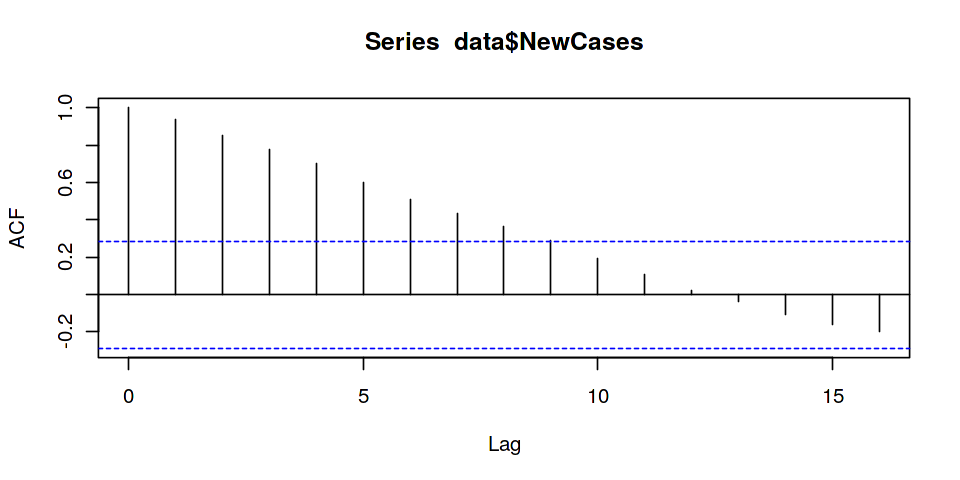

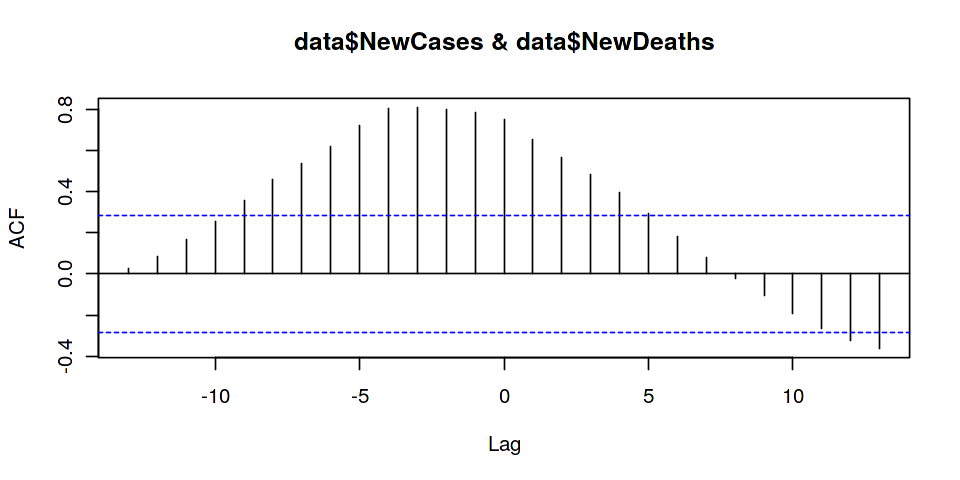

In [73]:
data <- covidLaggedOneState
data <- data[data$Race=="White", ]
data <- data[complete.cases(data), ]
acf(data$NewCases)
ccf(data$NewCases, data$NewDeaths)